 ### Scaling Preprocessing
- 0 ~ 1, -1 ~ 1, z-score 변환 중에서 한 개를 선택하여 범위를 축소하는 작업을 의미한다.
- Pretrained Model은 주로 tf(tensorflow)와 torch 프레임워크 방식을 사용한다.
- tf는 -1 ~ 1, torch는 z-score 변환하는 것이 각 프레임워크의 전통이다.

<img src="./images/scaling.png" width="400" style="margin-top:20px;">

In [4]:
with open('./datasets/animals/translate.py') as f:
    content = f.readline().strip()
    # print(content)
    # 문자열 안에 있는 딕셔너리를 정상적으로 가져오기 위한 메소드 eval
    contents1 = eval(content[content.index("{"):content.index("}") + 1])
    contents2 = {v: k for k, v in contents1.items()}

print(contents1, contents2, sep='\n\n')


{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}

{'dog': 'cane', 'horse': 'cavallo', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'sheep': 'pecora', 'squirrel': 'scoiattolo', 'cane': 'dog', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'ragno': 'spider', 'scoiattolo': 'squirrel'}


In [5]:
from glob import glob
import os

root = './datasets/animals/original/'

directories = glob(os.path.join(root, '*'))
print(directories)

for directory in directories:
    old_name = os.path.basename(directory)  # 플랫폼 독립적으로 디렉토리 이름 추출
    try:
        new_name = contents1[old_name]
    except KeyError:
        new_name = contents2.get(old_name, old_name)  # old_name이 contents2에 없으면 그대로 유지
    new_directory = os.path.join(root, new_name)
    os.rename(directory, new_directory)
    

['./datasets/animals/original/gallina', './datasets/animals/original/ragno', './datasets/animals/original/gatto', './datasets/animals/original/farfalla', './datasets/animals/original/mucca', './datasets/animals/original/cavallo', './datasets/animals/original/cane', './datasets/animals/original/pecora', './datasets/animals/original/scoiattolo', './datasets/animals/original/elefante']


In [6]:
root = './datasets/animals/original/'
    
directories = glob(os.path.join(root, '*'))
directory_names = []
for directory in directories:
    directory_names.append(os.path.basename(directory))

print(directory_names)

['cat', 'butterfly', 'dog', 'sheep', 'spider', 'chicken', 'horse', 'squirrel', 'cow', 'elephant']


In [7]:
root = './datasets/animals/original/'

for name in directory_names:
    for i, file_name in enumerate(os.listdir(os.path.join(root, name))):
        old_file = os.path.join(root + name + '/', file_name)
        new_file = os.path.join(root + name + '/', name + str(i + 1) + '.png')

        os.rename(old_file, new_file)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 13032 images belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [10]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'butterfly',
 1: 'cat',
 2: 'chicken',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'horse',
 7: 'sheep',
 8: 'spider',
 9: 'squirrel'}

In [11]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [22]:
import pandas as pd

animal_df = pd.DataFrame({'file_paths': generator.filepaths,'target_names': target_names, 'targets': generator.classes})
animal_df

,file_paths,target_names,targets
0,./datasets/animals/original/butterfly/butterfl...,butterfly,0
1,./datasets/animals/original/butterfly/butterfl...,butterfly,0
2,./datasets/animals/original/butterfly/butterfl...,butterfly,0
3,./datasets/animals/original/butterfly/butterfl...,butterfly,0
4,./datasets/animals/original/butterfly/butterfl...,butterfly,0
...,...,...,...
13027,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
13028,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
13029,./datasets/animals/original/squirrel/squirrel9...,squirrel,9
13030,./datasets/animals/original/squirrel/squirrel9...,squirrel,9


In [23]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(animal_df.file_paths, 
                 animal_df.targets, 
                 stratify=animal_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
4    1949
8    1914
2    1230
6    1025
0     863
3     743
9     738
7     722
1     667
5     574
Name: count, dtype: int64
targets
4    488
8    479
2    307
6    256
0    216
3    186
9    184
7    181
1    167
5    143
Name: count, dtype: int64


In [24]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, 
                 train_targets, 
                 stratify=train_targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())
print(test_targets.value_counts())

targets
4    1559
8    1531
2     984
6     820
0     690
3     595
9     590
7     578
1     534
5     459
Name: count, dtype: int64
targets
4    390
8    383
2    246
6    205
0    173
3    148
9    148
7    144
1    133
5    115
Name: count, dtype: int64
targets
4    488
8    479
2    307
6    256
0    216
3    186
9    184
7    181
1    167
5    143
Name: count, dtype: int64


In [25]:
train_df = animal_df.iloc[train_images.index].reset_index(drop=True)
validation_df = animal_df.iloc[validation_images.index].reset_index(drop=True)
test_df = animal_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(8340, 3)
(2085, 3)
(2607, 3)


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 64

def transform(image):
    aug = A.HorizontalFlip(p=0.5)

    return aug(image=image)['image']

train_generator = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255)

# flow_from_dataframe에서 y_col에 들어갈 타겟 데이터는 문자열 타입만 가능하다.
train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 8340 validated image filenames belonging to 10 classes.
Found 2085 validated image filenames belonging to 10 classes.
Found 2607 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 70s 1us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 31, 31,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 31, 31,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 31, 31,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 29, 29,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 29, 29,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 29, 29,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 29, 29,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 29, 29,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 29, 29,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 29, 29,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 29, 29,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 15, 15,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 15, 15,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 15, 15,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 15,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 15, 15,    │          0 │ add[0][0]       

 Total params: 20,964,440 (79.97 MB)

 Trainable params: 20,909,912 (79.76 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [30]:
import gc

gc.collect()

729

In [31]:
N_EPOCHS = 10

history = model.fit(train_flow, 
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_flow, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 28/261 ━━━━━━━━━━━━━━━━━━━━ 2:31 651ms/step - acc: 0.1498 - loss: 2.3125

KeyboardInterrupt: 

In [32]:
model.evaluate(test_flow)

82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - acc: 0.1827 - loss: 7.9347


[7.792629241943359, 0.18718834221363068]

In [33]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)

NameError: name 'history' is not defined

## Scaling

In [34]:
def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

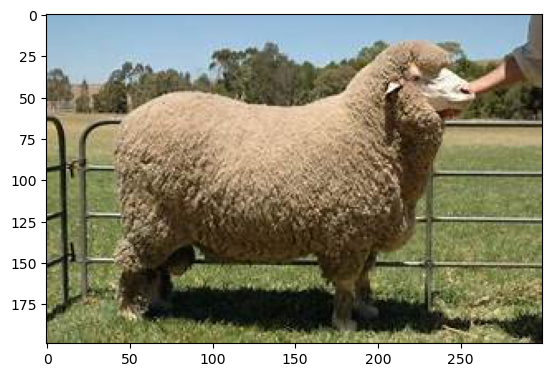

In [50]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[10]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [51]:
scaled_image_tf = preprocessing_scaling(image, mode='tf')
scaled_image_torch = preprocessing_scaling(image, mode='torch')

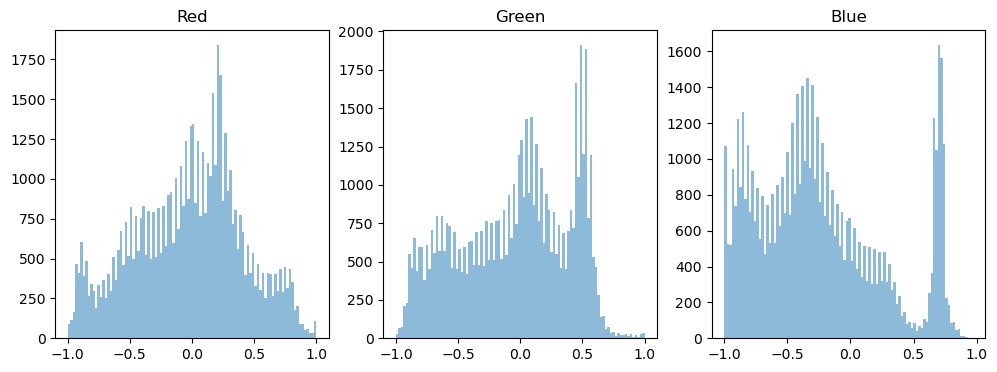

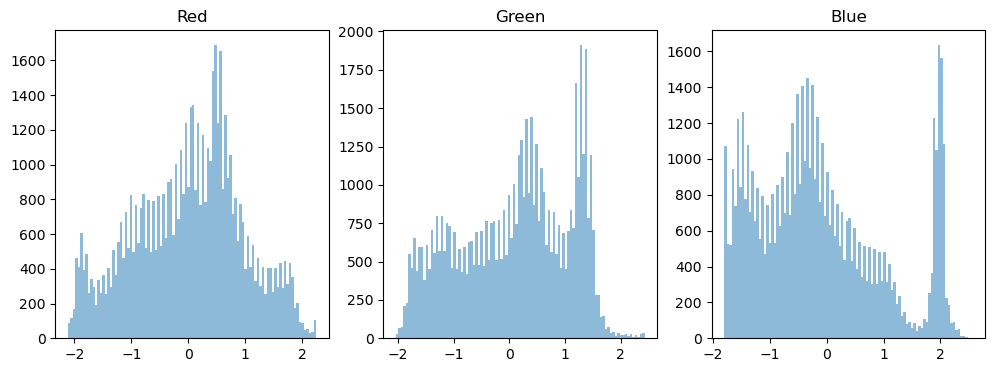

In [52]:
def show_pixel_histogram(image):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    titles = ['Red', 'Green', 'Blue']
    for i in range(3):
        axs[i].hist(image[:, :, i].flatten(), bins=100, alpha=0.5)
        title_str = titles[i]
        axs[i].set(title=title_str)

show_pixel_histogram(scaled_image_tf)
show_pixel_histogram(scaled_image_torch)

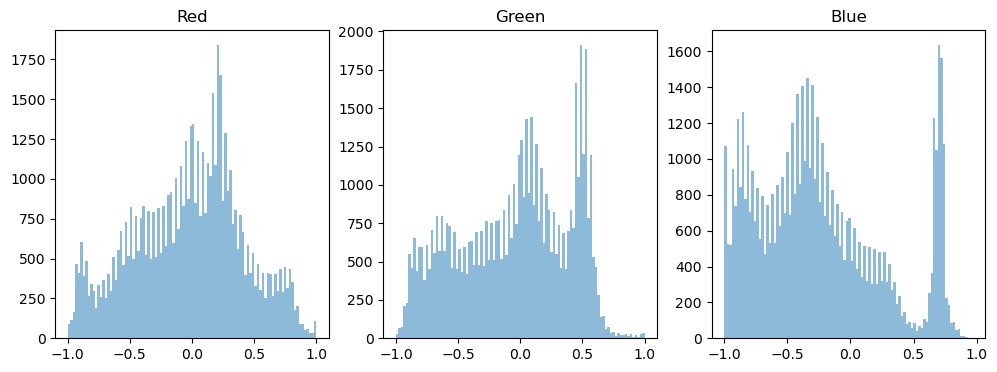

In [53]:
from tensorflow.keras.applications.xception import preprocess_input

# Xception의 scaling 방식은 tf
scaled_image_xception = preprocess_input(image)
show_pixel_histogram(scaled_image_xception)

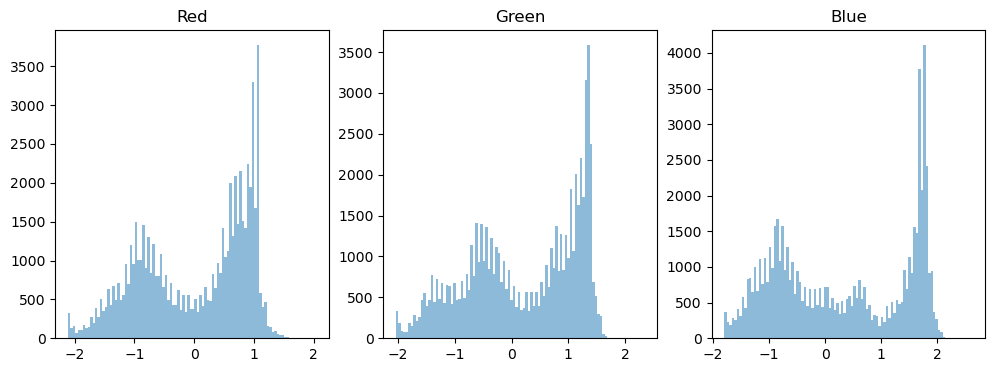

In [48]:
from tensorflow.keras.applications.densenet import preprocess_input

# DenseNet의 scaling 방식은 torch
scaled_image_densnet = preprocess_input(image)
show_pixel_histogram(scaled_image_densnet)

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

IMAGE_SIZE = 64
BATCH_SIZE = 64

def preprocessing_scaling_for_train(image, mode='tf'):
    aug = A.HorizontalFlip(p=0.5)
    image = aug(image=image)['image']
    
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

def preprocessing_scaling(image, mode='tf'):
    if mode == 'tf': # -1 ~ 1 scale
        image = image / 127.5
        image -= 1.
    
    elif mode == 'torch': # z-score scale
        image = image / 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        image[:, :, 0] = (image[:, :, 0] - mean[0])/std[0]
        image[:, :, 1] = (image[:, :, 1] - mean[1])/std[1]
        image[:, :, 2] = (image[:, :, 2] - mean[2])/std[2]
        
    return image

train_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling_for_train)
validation_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)
test_generator = ImageDataGenerator(preprocessing_function=preprocessing_scaling)

train_flow = train_generator.flow_from_dataframe(dataframe=train_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_flow = validation_generator.flow_from_dataframe(dataframe=validation_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

test_flow = test_generator.flow_from_dataframe(dataframe=test_df, 
                                                 x_col='file_paths', 
                                                 y_col='target_names',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 class_mode='categorical')

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 8340 validated image filenames belonging to 10 classes.
Found 2085 validated image filenames belonging to 10 classes.
Found 2607 validated image filenames belonging to 10 classes.
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
